In [1]:
%%writefile temp_ip_linear_vtem.py
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
from simpegEMIP.TDEM import geteref, Problem3D_Inductive, Survey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
# %matplotlib inline
# import matplotlib 
# matplotlib.rcParams["font.size"] = 14
eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
actinds = ~airind
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
layerind = (np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 0.005
c = np.ones(mesh.nC) * 0.5

actmapeta = Maps.InjectActiveCells(mesh, actinds, 0.)
actmaptau = Maps.InjectActiveCells(mesh, actinds, 0.005)
actmapc = Maps.InjectActiveCells(mesh, actinds, 0.5)

wires = Maps.Wires(('eta', actmapeta.nP), ('tau', actmapeta.nP), ('c', actmapeta.nP))

taumap = actmaptau*wires.tau
etamap = actmapeta*wires.eta
cmap = actmapc*wires.c

m = np.r_[eta[actinds], tau[actinds], c[actinds]]
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 1.47e-3

rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
tpeak = 2.73e-3
# t0 = 4.2e-3
t0 = tpeak + dt
rx_vtem = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, orientation='z')
src_vtem = EM.TDEM.Src.CircularLoop([rx_vtem], waveform=EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.), loc=srcloc)
survey_vtem = EM.TDEM.Survey([src_vtem])
prb_em_vtem = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_vtem.verbose = True
prb_em_vtem.timeSteps = [(tpeak/10, 10), ((t0-tpeak)/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_vtem.Solver = PardisoSolver
prb_em_vtem.pair(survey_vtem)
F_vtem = prb_em_vtem.fields(sigmaInf)
data_vtem = survey_vtem.dpred(sigmaInf, f=F_vtem)
cur = []
for t in prb_em_vtem.times:
    cur.append(src_vtem.waveform.eval(t))
cur = np.hstack(cur)

eref_vtem = geteref(F_vtem[src_vtem, 'eSolution', :], mesh, option=None, tInd=20) 
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx_ip_vtem = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_ip_vtem = EM.TDEM.Src.CircularLoop([rx_ip_vtem], waveform=EM.TDEM.Src.RampOffWaveform(offTime=0.), loc=srcloc)
dt = 1.47e-3
survey_ip_vtem = Survey([src_ip_vtem])
t1, t2, t3 = dt, t0-0.001365, t0
prb_ip_vtem = Problem3D_Inductive(
    mesh, 
    sigmaInf=sigmaInf, 
    eta=eta, 
    tau=tau, 
    c=c, 
    actinds = ~airind,
    tlags = [0., t1, t2, t3]
)
prb_ip_vtem.Solver = PardisoSolver
prb_ip_vtem.pair(survey_ip_vtem)
prb_ip_vtem.set_eref(eref_vtem)
ip_vtem_approx = survey_ip_vtem.dpred(m)

Overwriting temp_ip_linear_vtem.py


In [2]:
!python temp_ip_linear_vtem.py

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:399: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)
>> Compute Sensitivity matrix
 1 / 1
*** PROFILER RESULTS ***
fields (/Users/sgkang/Projects/simpegEM1D/simpegem1d/EM1D.py:182)
function called 0 times

         0 function calls in 0.000 seconds

   Ordered by: cumulative time, internal time, call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        0    0.000             0.000          profile:0(profiler)



*** PROFILER RESULTS ***
HzKernel_layer (/Users/sgkang/Projects/simpegEM1D/simpegem1d/EM1D.py:93)
function called 0 times

         0 function calls in 0.000 seconds

   Ordered by: cumulative time, internal time, call count

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        0    0.000             0.000          profile:0(profiler)



*** PROF

In [6]:
dt = 1.47e-3
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+dt, 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=dt), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(dt/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)
eref_ramp = geteref(F_ramp[src_ramp, 'eSolution', :], mesh, option=None, tInd=10) 

rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx_ip_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src_ip_ramp = EM.TDEM.Src.CircularLoop([rx_ip_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=0.), loc=srcloc)

survey_ip_ramp = Survey([src_ip_ramp])
prb_ip_ramp = Problem3D_Inductive(
    mesh, 
    sigmaInf=sigmaInf, 
    etaMap=etamap, 
    tauMap=taumap, 
    cMap=cmap, 
    actinds = ~airind,
    tlags = [0., dt]
)
prb_ip_ramp.Solver = PardisoSolver
prb_ip_ramp.pair(survey_ip_ramp)
prb_ip_ramp.set_eref(eref_ramp)
ip_ramp_approx = survey_ip_ramp.dpred(m)

>> Compute Sensitivity matrix
 1 / 1

In [13]:
data = np.load("data.npy")
data_ramp = np.load("data_ramp.npy")
data_vtem = np.load("data_vtem.npy")

data_em = np.load("dataem.npy")
data_em_ramp = np.load("dataem_ramp.npy")
data_em_vtem = np.load("dataem_vtem.npy")
ip = data - data_em
ip_ramp = data_ramp - data_em_ramp
ip_vtem = data_vtem - data_em_vtem

In [14]:
data_ramp_approx = data_em_ramp + ip_ramp_approx
data_vtem_approx = data_em_vtem + ip_vtem_approx

In [15]:
# J = np.load("J.npy")

In [16]:
# plt.semilogy(abs(J[actinds]))
# plt.semilogy(abs(prb_ip_ramp.J.flatten())[actinds], '.')

In [17]:
# plt.loglog(rx_ip_ramp.times, -data_ramp, 'k')
# plt.loglog(rx_ip_ramp.times, data_ramp, '--k')
# plt.loglog(rx_ip_ramp.times, -data_em_ramp, 'b-')
# plt.loglog(rx_ip_ramp.times, ip_ramp, 'r-')
# plt.plot(rx_ip_ramp.times, ip_ramp_approx, 'r.')

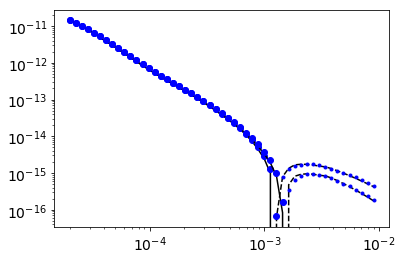

In [18]:
plt.loglog(rx_ip_ramp.times, -data_ramp, 'k')
plt.loglog(rx_ip_ramp.times, data_ramp, '--k')
plt.loglog(rx_ip_ramp.times, -data_ramp_approx, 'bo')
plt.loglog(rx_ip_ramp.times, data_ramp_approx, 'b.')

plt.loglog(rx_ip_ramp.times, -data_vtem, 'k')
plt.loglog(rx_ip_ramp.times, data_vtem, '--k')
plt.loglog(rx_ip_ramp.times, -data_vtem_approx, 'bo')
plt.loglog(rx_ip_ramp.times, data_vtem_approx, 'b.')